In [515]:
from qiskit import IBMQ
import datetime
import pandas as pd
import os
from qiskit.providers.models import BackendProperties
from qiskit import IBMQ


class IBMMachinePropertiesFactory:
    def __init__(self, provider):
        self.provider = provider

    @property
    def machines(self):
        machines = []
        backends = self.provider.backends()
        for backend_i in backends:
            # skip simulators
            if (backend_i.configuration().backend_name) == ('ibmq_qasm_simulator') or (backend_i.configuration().backend_name) == ('simulator_statevector')\
                    or (backend_i.configuration().backend_name) == ('simulator_mps') or (backend_i.configuration().backend_name) == ('simulator_extended_stabilizer') \
                    or (backend_i.configuration().backend_name) == ('simulator_stabilizer') or (backend_i.configuration().backend_name) == ('ibmq_armonk'):
                continue
            machines.append(backend_i.configuration().backend_name)
        return machines


    def query_backend_info(self, backend_name, query_date=None):
        """Query info about a given backend at a specific time. Returns a tuple (datetime, info)."""
        backend = self.provider.get_backend(backend_name)
        config = backend.configuration()
        props = backend.properties(datetime=query_date)
        if props is None:
            return None, None
        return config,props,backend


class MyBackendNoise(object):
    def __init__(self,backend_name,provider,timestamp= None):
        self.__property = None
        self.__noise = None
        self.__backend_name = backend_name
        self.__timestamp = timestamp
        self.provider = provider

    def __create__property(self):
        if self.__property == None:
            backend = self.provider.get_backend(self.__backend_name)
            props = backend.properties(datetime=self.__timestamp)
            self.__property = props

    def set_property(self,property):
        self.__property = property
        self.__property2noise()

    def set_noise(self,noise):
        self.__noise = noise
        self.__noise2property()

    def __create_noise_version(self):
        noise_version = {
        'backend_name':[self.__backend_name],
        'timestamp': [self.__property.last_update_date]}
        return noise_version
    
    def __property2noise(self):
        noise_version = self.__create_noise_version()
        for gate_i in self.__property.gates:
            gate_name = gate_i.gate
            if gate_name not in ['reset']:
                noise_version[gate_i.name] = gate_i.parameters[0].value
        property_dict =  self.__property.to_dict()
        i = 0
        for qubit in property_dict['qubits']:
            for info in qubit:
                if info['name'] in ['T1','T2','frequency','readout_error','prob_meas0_prep1','prob_meas1_prep0']:
                    noise_version[info['name']+'_q'+str(i)]= info['value']
            i = i+1
        self.__noise = noise_version
        

    def __noise2property(self):
        self.__create__property()
        property_dict = self.__property.to_dict()
        i = 0
        for qubit in property_dict['qubits']:
            for info in qubit:
                if info['name'] in ['T1','T2','frequency','readout_error','prob_meas0_prep1','prob_meas1_prep0']:
                    info['value'] = self.__noise[info['name']+'_q'+str(i)]
            i = i+1
        for gate_i in property_dict['gates']:
            gate_name = gate_i["gate"]
            if gate_name not in ['reset']:
                gate_i["parameters"][0]["value"] = self.__noise[gate_i["name"]]
        self.__property = BackendProperties.from_dict(property_dict)
        


    def get_property(self):
        return self.__property

    def get_noise(self):
        return self.__noise
    



provider = IBMQ.get_provider(hub='ibm-q-ornl',group='ornl',project='csc517')
property_factory = IBMMachinePropertiesFactory(provider)

backend_name = 'ibm_algiers'
fname = 'C:/Users/x876r/Documents/Research/Coherence Witness/{}-{}.csv'.format(backend_name, datetime.datetime.now().strftime("%Y-%m-%d-%H-%M"))
start = datetime.datetime(2023,7,1)
end = datetime.datetime(2023,7,4)
delta = datetime.timedelta(days=1) #query gap
delta2 = datetime.timedelta(minutes=30) #gap between query and record


while start <= end:
 
    query_date = start + delta2
    config, prop, backend = property_factory.query_backend_info(backend_name, query_date)
    prop_dict = prop.to_dict()


    my_backend = MyBackendNoise(backend_name,provider,query_date)
    my_backend.set_property(prop)
    noise =  my_backend.get_noise()

    date_format =  "%Y-%m-%d-%H-%M"
    timestamp = start.strftime(date_format)
    

    df = pd.DataFrame.from_dict(noise)
    print(noise['timestamp'])
    # df.to_csv(fname)
    if os.path.isfile(fname):
        df.to_csv(fname, mode = 'a', index = False, header = False)
    else:
        df.to_csv(fname, mode = 'w', index = False, header = True)

    start += delta

[datetime.datetime(2023, 6, 30, 22, 30, 51, tzinfo=tzlocal())]
[datetime.datetime(2023, 7, 2, 0, 23, 18, tzinfo=tzlocal())]
[datetime.datetime(2023, 7, 2, 22, 25, 3, tzinfo=tzlocal())]
[datetime.datetime(2023, 7, 3, 22, 42, 25, tzinfo=tzlocal())]


In [99]:
from qiskit import *
import numpy as np
from qiskit import IBMQ

token='a2afa69f70955de3c84068e58c44bd81e01740c07ff40db7e9ab824c0da8b9412da7a86e9c453f7f97ecc35fc9f09948ce053cbd9e8213b98feadba15dcc467f'
#IBMQ.enable_account(token)
IBMQ.save_account(token,overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl',group='ornl',project='csc517')
#setting the backend to the real machine this circuit is optimized for in order to transpile correctly
backend = provider.get_backend('ibm_algiers')
backend_config = backend.configuration()
backend_properties = backend.properties()

ibmqfactory.load_account:WARNING:2023-07-24 20:46:21,583: Credentials are already in use. The existing account in the session will be replaced.


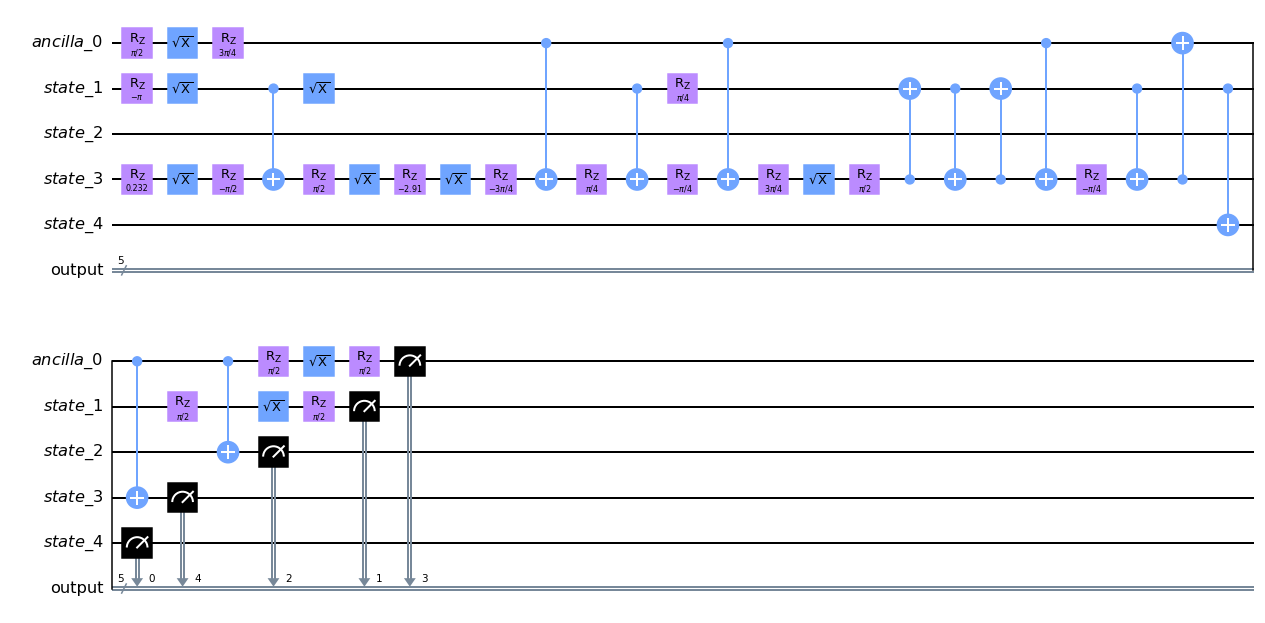

In [661]:
ancilla = QuantumRegister(1, 'ancilla_0')
A = QuantumRegister(1,'state_1')
B = QuantumRegister(1,'state_2')
C = QuantumRegister(1,'state_3')
D = QuantumRegister(1,'state_4')
Meas = ClassicalRegister(5,'output')

circuit = QuantumCircuit(ancilla, A, B, C, D, Meas)
circuit1 = QuantumCircuit(ancilla, A, B, C, D, Meas)

#angle between adjacent states
angle = 0.5*np.pi

#initialization circuit. This changes when the angle is changed
circuit1.initialize([np.cos(1*angle/2),np.sin(1*angle/2)],B)
circuit1.initialize([np.cos(2*angle/2),np.sin(2*angle/2)],C)
circuit1.initialize([np.cos(3*angle/2),np.sin(3*angle/2)],D)

#Bell measurement qiskit transpile optimized circuit. This circuit does not change
circuit.rz(1.5707963267948966, ancilla)
circuit.sx(ancilla)
circuit.rz(2.356194490192345, ancilla)
circuit.rz(0.23182380450040263, C)
circuit.sx(C)
circuit.rz(-1.5707963267948966, C)
circuit.rz(-3.141592653589793, A)
circuit.sx(A)
circuit.cx(A, C)
circuit.sx(A)
circuit.rz(1.5707963267948966, C)
circuit.sx(C)
circuit.rz(-2.9097688490893905, C)
circuit.sx(C)
circuit.rz(-2.3561944901923457, C)
circuit.cx(ancilla, C)
circuit.rz(0.7853981633974483, C)
circuit.cx(A, C)
circuit.rz(0.7853981633974483, A)
circuit.rz(-0.7853981633974483, C)
circuit.cx(ancilla, C)
circuit.rz(2.356194490192345, C)
circuit.sx(C)
circuit.rz(1.5707963267948966, C)
circuit.cx(C, A)
circuit.cx(A, C)
circuit.cx(C, A)
circuit.cx(ancilla, C)
circuit.rz(-0.7853981633974483, C)
circuit.cx(A, C)
circuit.cx(C, ancilla)
circuit.cx(ancilla, C)
circuit.cx(ancilla, B)
circuit.rz(1.5707963267948966, ancilla)
circuit.sx(ancilla)
circuit.rz(1.5707963267948966, ancilla)
circuit.cx(A, D)
circuit.rz(1.5707963267948966, A)
circuit.sx(A)
circuit.rz(1.5707963267948966, A)

#The qubits are assigned in reverse to the classical regsiter in order to get the expected bit order: ancilla,A,B,C,D
circuit.measure(D, 0)
circuit.measure(A, 1)
circuit.measure(B, 2)
circuit.measure(ancilla, 3)
circuit.measure(C, 4)
    

circuit.draw(output='mpl')

In [662]:
#These were the ideal qubits at the time of the test on the real machine. Qubit topology is a 1D line
#ancilla -> q5, state 1 -> q11, state 2 -> q3, state 3 -> q8, state 4 -> q14
layout = [5,11,3,8,14]
initialize = transpile(circuit1, backend, optimization_level=1, initial_layout=layout, seed_transpiler=42, routing_method='basic')
Bellmeasure = transpile(circuit, backend, optimization_level=1, initial_layout=layout, seed_transpiler=42, routing_method='basic')

#add the initialization and Bell measurement circuits together
final = initialize.compose(Bellmeasure)
final.draw('mpl',cregbundle=False,idle_wires=False)

#I did 10k shots per data point when measuring on real machines and did 5 runs
#50k shots on a simulation should represent that amount of data
shots = 50000

#for running on a real machine:
#job = backend.run(final,shots=shots)

In [663]:
#I had trouble importing the simulators and noise features, probably because of version differences
from qiskit.providers.aer.noise.errors.standard_errors import kraus_error,mixed_unitary_error,coherent_unitary_error,pauli_error,depolarizing_error,reset_error,thermal_relaxation_error
import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise.device import (basic_device_readout_errors,basic_device_gate_errors)

#use the real machine backend to set up what the qubit connection layout will look like
coupling_map = backend.configuration().coupling_map

# Error probabilities, example error rates based on the rates at the time of the real experiment
prob_1 = 0.0005  # 1-qubit gate, between 0.00025 and 0.0007
prob_2 = 0.0   # 2-qubit gate, each 2-qubit connection has usually between 0.5% and 3% fixed error rates
prob_3 = 0.015     # readout, each qubit usually has a fixed error rate between 0.75% and 2.5%
prob_4 = 0.015

#layout = [5,11,3,8,14] -> bits 01234
#measurementerror is formatted -> [prob of measuring 1 when in state 0,prob of measuring 0 when in state 1] for each qubit 01234
#sample values from real machine measurementerror = [[0.0054,0.0082],[0.0094,0.0166],[0.0122,0.0128],[0.0098,0.011],[0.021,0.0252]]
measurementerror = [[0.008,0.006],[0.00960000000000005,0.0064],[0.0125999999999999,0.0152],[0.00880000000000003,0.0078],[0.01,0.0366666666666666]]
#measurementerror = [[prob_3,prob_4],[prob_3,prob_4],[prob_3,prob_4],[prob_3,prob_4],[prob_3,prob_4]]


"""
probabilities = [[1]*32 for _ in range(32)]


for i in range(32):
    bitreal = f'{i:05b}'
    for s in range (32):
        biterror = f'{s:05b}'
        for bit in range(5):

            if bitreal[bit] == biterror[bit]:
                probabilities[i][s] = probabilities[i][s]*(1 - measurementerror[bit][int(biterror[bit])])
            else:
                probabilities[i][s] = probabilities[i][s]*measurementerror[bit][int(biterror[bit])]
    normalize = sum(probabilities[i])
    for s in range(32):
        probabilities[i][s] = probabilities[i][s]/normalize
                       
"""    


"""Alternate method of setting up the probabilities
Creates fixed probability for the correct state based on a single error rate
Distributes remaining probability equally among error states (this is wrong, states with more errors should be more rare)
probabilities = np.diag([1-prob_3]*32)
for i in range (32):
    for s in range (32):
        if probabilities[i][s]==0:
            probabilities[i][s] = prob_3/31 
"""
            
            
# Depolarizing quantum errors
#1 qubit gate errors:
error_1 = noise.depolarizing_error(prob_1, 1)
#2 qubit gate errors:
error_2 = noise.depolarizing_error(prob_2, 2)
#readout errors:
#readout_error = noise.ReadoutError(probabilities)


# Add errors to noise model
noise_model = noise.NoiseModel()

"""for qubits, error in basic_device_readout_errors(backend_properties):
    noise_model.add_readout_error(error, qubits)
"""
#1 qubit gate errors:
noise_model.add_all_qubit_quantum_error(error_1, ['rz', 'sx'])
#2 qubit gate errors:
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])


def add_readout_errors(noise_model,layout,measurementerror):
    for qubit in range(5):
        qubits = [layout[qubit]]
        probabilities = [[1-measurementerror[qubit][0],measurementerror[qubit][0]],[measurementerror[qubit][1],1-measurementerror[qubit][1]]]
        readout_error = noise.ReadoutError(probabilities)
        noise_model.add_readout_error(readout_error,qubits)

#readout errors:
add_readout_errors(noise_model,layout,measurementerror)

"""for qubits, _ in basic_device_readout_errors(backend_properties):
    probabilities = [[1-measurementerror[0][0],measurementerror[0][0]],[1-measurementerror[0][1],measurementerror[0][1]]]
    error = noise.ReadoutError(probabilities)
    noise_model.add_readout_error(error, qubits)
    print(qubits)
"""        
# Get basis gates from noise model
basis_gates = noise_model.basis_gates

print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['measure', 'rz', 'sx']
  Qubits with noise: [3, 5, 8, 11, 14]
  All-qubits errors: ['rz', 'sx']
  Specific qubit errors: [('measure', (5,)), ('measure', (11,)), ('measure', (3,)), ('measure', (8,)), ('measure', (14,))]


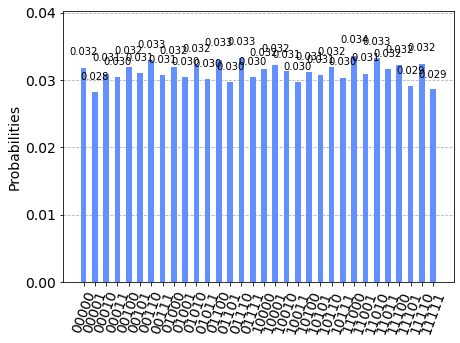

In [664]:
from qiskit.providers.aer.backends.aer_simulator import AerSimulator

#change from real machine to simulator
simulator = Aer.get_backend('qasm_simulator')
backend = AerSimulator(noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates)

#run simulator
result = backend.run(final,shots=shots).result()

counts = result.get_counts(final)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [665]:
#Inequality calculations

r12 = 1-4*(counts.get('01100',0)+counts.get('01101',0)+counts.get('01110',0)+counts.get('01111',0))/shots
print(f"r_12 = {r12}")
r23 = 1-4*(counts.get('11100',0)+counts.get('11101',0)+counts.get('11110',0)+counts.get('11111',0))/shots
print(f"r_23 = {r23}")
r34 = 1-4*(counts.get('00011',0)+counts.get('00111',0)+counts.get('01011',0)+counts.get('01111',0))/shots
print(f"r_34 = {r34}")
r14 = 1-4*(counts.get('10011',0)+counts.get('10111',0)+counts.get('11011',0)+counts.get('11111',0))/shots
print(f"r_14 = {r14}")

inequality = r12 + r23 + r34 - r14

print(f"r_12 + r_23 + r_34 - r_14 = {inequality}")

#formatted for creating a csv: CNOT error rate,angle between adjacent states,r12,r23,r34,r14,inequality value
print(f"\nraw:\n{prob_2},{angle/np.pi},{r12},{r23},{r34},{r14},{inequality}")

r_12 = 0.49424
r_23 = 0.51064
r_34 = 0.51312
r_14 = 0.5187200000000001
r_12 + r_23 + r_34 - r_14 = 0.99928

raw:
0.0,0.5,0.49424,0.51064,0.51312,0.5187200000000001,0.99928
